In [1]:
from thesispy.experiments.wandb_client import *
from thesispy.experiments.validation import VALIDATION_NAMES_NEW, VALIDATION_ABBRVS_NEW
from thesispy.experiments.wandb_client import get_runs_as_dataset
from thesispy.experiments.validation import *
from thesispy.plot_utils import *
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np
from scipy.stats import ttest_ind

In [2]:
ds = get_runs_as_dataset("synthetic_1_linkage_models", {"config.StaticLinkageMaxSetSize": {"$in": [12, 24]}})
arrs = ds.aggregate_for_plot(["FosElementSize", "MeshSize"])

In [3]:
mean_runtimes = {}
std_runtimes = {}

for group, runs in ds.groupby(["FosElementSize", "MeshSize"]):
    mean_runtimes[group] = np.mean([run.summary["_runtime"] for run in runs])
    std_runtimes[group] = 0.2 * np.std([run.summary["_runtime"] for run in runs])

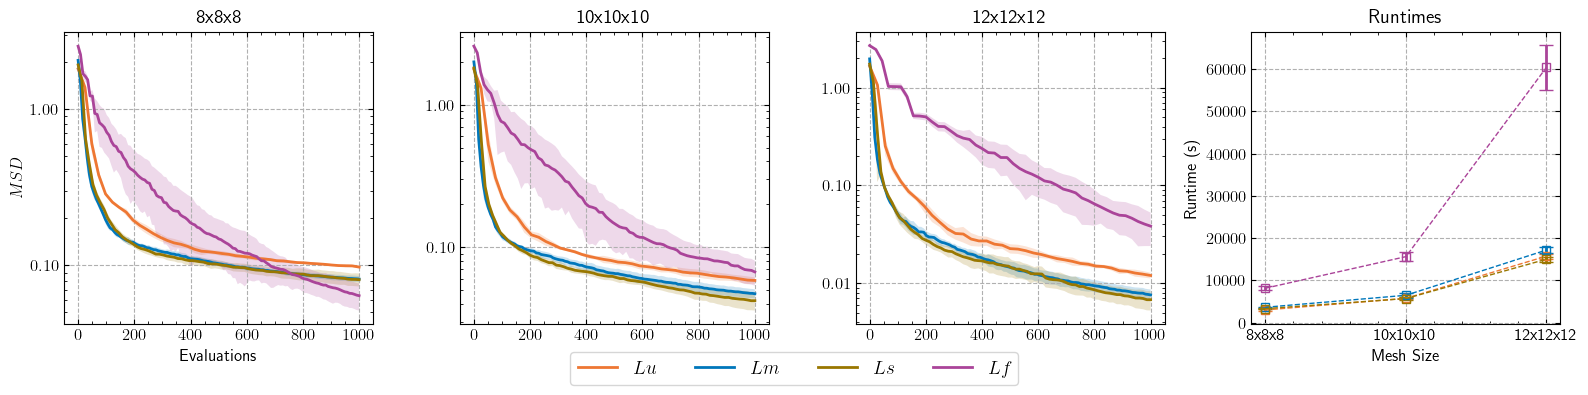

In [4]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

labels = {
    1: "$Lu$",
    -6: "$Lm$",
    -3: "$Ls$",
    -1: "$Lf$"
}

run_times = []

for fos_size in [1, -6, -3, -1]:
    mean_runtimes_ = []
    std_runtimes_ = []

    for i, mesh_size in enumerate([(5, 5, 5), (7, 7, 7), (9, 9, 9)]):
        arr_avg, arr_median, arr_std = arrs[(fos_size, mesh_size)]
        xs = np.linspace(0, 1000, len(arr_median))
        axes[i].plot(xs, arr_median, label=labels[fos_size])
        axes[i].fill_between(xs, arr_median - arr_std, arr_median + arr_std, alpha=0.2)
        
        # formatting
        axes[i].set_yscale("log")
        axes[i].yaxis.set_major_formatter(ScalarFormatter())
        axes[i].set_title(mesh_size_as_str(mesh_size), loc="center", fontsize=14)

        mean_runtimes_.append(mean_runtimes[(fos_size, mesh_size)])
        std_runtimes_.append(std_runtimes[(fos_size, mesh_size)])
    
    axes[3].errorbar(
                    [1, 2, 3],
                    mean_runtimes_,
                    yerr=std_runtimes_,
                    fmt="--s",
                    markerfacecolor='none',
                    label=labels[fos_size],
                    capsize=5,
                    capthick=1,
                    elinewidth=2,
                    markersize=6,
                    linewidth=1
    )


axes[3].set_xticks([1, 2, 3], ["8x8x8", "10x10x10", "12x12x12"], fontsize=12)
axes[3].set_xlabel("Mesh Size", fontsize=12)
axes[3].set_ylabel("Runtime (s)", fontsize=12)
axes[3].set_title("Runtimes", loc="center", fontsize=14)

axes[0].set_xlabel("Evaluations", fontsize=12)
axes[0].set_ylabel("$MSD$", fontsize=12)
handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, ncol=4, loc="lower center", prop={'size': 14})

plt.tight_layout(rect=[0, 0.04, 1, 1])
# plt.savefig("subplots_metric_runtimes.pdf")

In [5]:
df = ds.aggregate(["FosElementSize", "MeshSize"], metrics=VALIDATION_NAMES_NEW, val=True)

In [9]:
int(False) * -1

0

In [10]:
from tabulate import tabulate

rows = []
mesh_size = "(5, 5, 5)"

for n, metric in enumerate(VALIDATION_NAMES_NEW):
    row = []
    row.append(VALIDATION_ABBRVS_NEW[n])

    dfs = []
    
    for i, fos_size in enumerate([1, -6, -3, -1]):
        df_fos = df.loc[(df.MeshSize == mesh_size) & (df.FosElementSize == str(fos_size))][metric]
        dfs.append(df_fos)

        avg = df_fos.mean()
        std = df_fos.std()

        row.append(f"{avg:.2f} $\pm$ {std:.2f}")

    best_index = None
    for f_i, a in enumerate(dfs):
        best = True
        for f_ib, b in enumerate(dfs):
            if f_i == f_ib:
                continue
            t, p = ttest_ind(a, b)
            not_better = a.mean() >= b.mean()
            if metric == "dice_sphere":
                not_better = a.mean() <= b.mean()
            if p > 0.05 or not_better:
                best = False
                break
        if best:
            best_index = f_i + 1
            break
    
    if best_index is not None:
        row[best_index] = "\\textbf{" + row[best_index] + "}"    

    rows.append(row)

print(tabulate(rows, headers=["placeholder"]*13, tablefmt="latex_raw"))

\begin{tabular}{lllll}
\hline
 placeholder             & placeholder     & placeholder              & placeholder     & placeholder              \\
\hline
 $TRE$                   & 1.81 $\pm$ 0.03 & \textbf{1.45 $\pm$ 0.09} & 1.64 $\pm$ 0.17 & 3.31 $\pm$ 0.31          \\
 $ASD_{\textsc{cube}}$   & 0.64 $\pm$ 0.01 & 0.49 $\pm$ 0.02          & 0.49 $\pm$ 0.01 & 0.74 $\pm$ 0.03          \\
 $ASD_{\textsc{sphere}}$ & 0.29 $\pm$ 0.01 & 0.28 $\pm$ 0.01          & 0.27 $\pm$ 0.01 & 0.46 $\pm$ 0.04          \\
 $DSC_{\textsc{sphere}}$ & 0.94 $\pm$ 0.00 & 0.96 $\pm$ 0.01          & 0.97 $\pm$ 0.01 & \textbf{0.98 $\pm$ 0.00} \\
 $E_b$                   & 0.50 $\pm$ 0.02 & \textbf{0.39 $\pm$ 0.03} & 0.45 $\pm$ 0.04 & 1.98 $\pm$ 0.31          \\
 $\vec{v}_{\epsilon}$    & 0.58 $\pm$ 0.01 & 0.59 $\pm$ 0.05          & 0.61 $\pm$ 0.06 & 1.75 $\pm$ 0.16          \\
\hline
\end{tabular}


In [8]:
from pathlib import Path
import seaborn as sns
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import numpy as np

out_dir = Path('../output/linkage/out/')
divisions = [1, 8, 64]

def get_mi_matrix(generation: int):
    return np.loadtxt(out_dir / "mutual_information_matrices.R0" / f"MI_matrix_{generation}.dat")

def compute_grid_point(index: int):
    p = np.zeros(3)
    for i in range(2, -1, -1):
        p[i] = index // divisions[i]
        index = index % divisions[i]
    return p

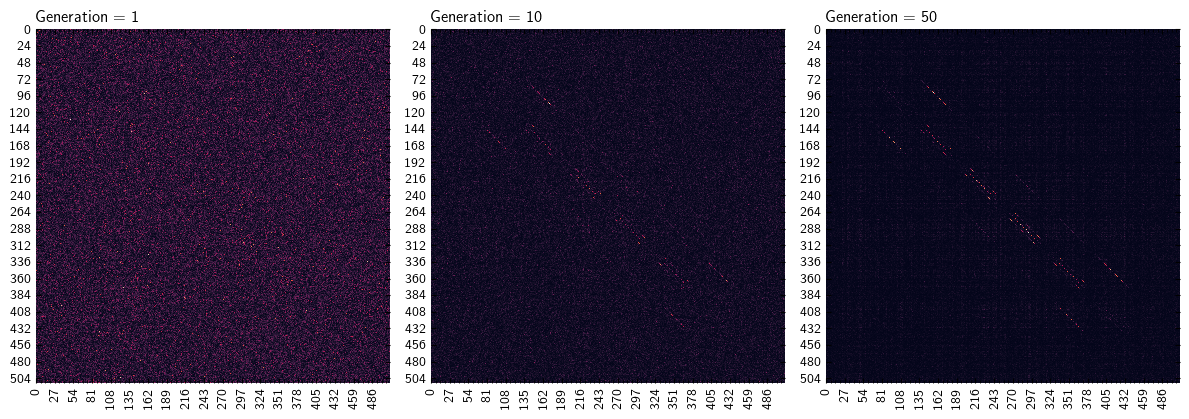

In [9]:
# plot heatmaps in subplot for generations in [1, 10, 50]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, generation in enumerate([1, 10, 50]):
    mi_matrix = get_mi_matrix(generation)
    sns.heatmap(mi_matrix, ax=axes[i], cbar=False, square=True)
    axes[i].set_title(f"Generation = {generation}", fontsize=12)

plt.tight_layout()
plt.savefig("subplots_mi_matrices.png")

In [95]:
# correlate euclidean distances of grid points with MI values
x = get_mi_matrix(58)
distances = []
mis = []
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        if i >= j:
            continue
        distances.append(euclidean(compute_grid_point(i), compute_grid_point(j)))
        mis.append(x[i, j])


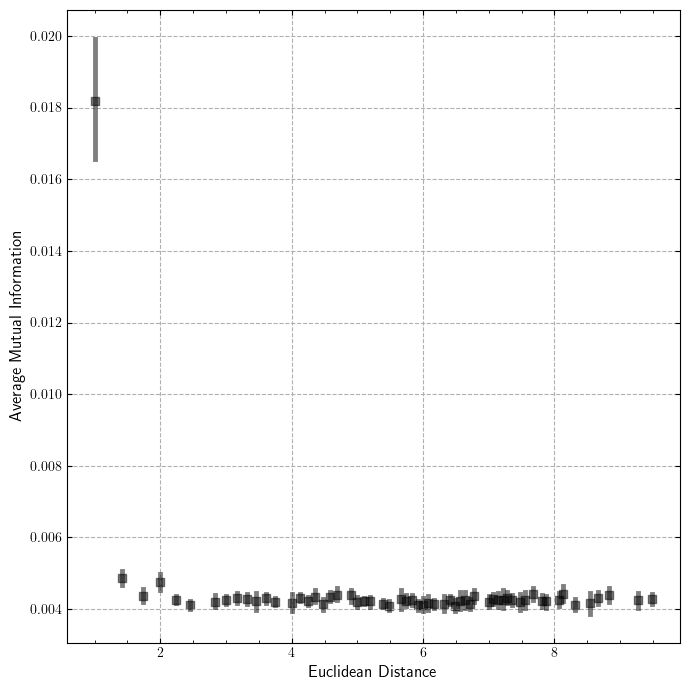

In [96]:
plt.figure(figsize=(7, 7))
sns.regplot(x=distances, y=mis, fit_reg=False, x_bins=100, marker="s",
    scatter_kws={"s": 30, "alpha": 0.5, "color": "black"},
)
plt.xlabel("Euclidean Distance")
plt.ylabel("Average Mutual Information")
plt.tight_layout()
plt.savefig("binned_scatter_euclidean_mi.pdf")

In [49]:
len(distances)

130816